<!-- HSV U-Net Model -->
<div class="alert" style="background: linear-gradient(to right, hsl(0,100%,50%), hsl(120,100%,50%), hsl(240,100%,50%)); color:white;">

# **U-NET HSV Colorization Model**
***
This notebook implements a U-Net model for image colorization using the HSV color space. The model takes grayscale images (Value channel) as input and predicts the Hue and Saturation channels.

### Key Features:
- HSV color space for intuitive color prediction
- Value channel as input (similar to grayscale)
- Predicts Hue (color) and Saturation (intensity)
- TensorBoard integration for monitoring
- Custom loss function for circular Hue values

### Model Architecture:
- Input: Grayscale image (mapped to Value channel)
- Output: Hue and Saturation channels
- Encoder: 3 levels with increasing filters (64, 128, 256)
- Bottleneck: 512 filters with dropout
- Decoder: 3 levels with skip connections
</div>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import datetime
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [2]:
def rgb_to_hsv(rgb_images):
    """Convert RGB images to HSV format."""
    # Ensure the input is in the correct range [0, 1]
    rgb_images = np.clip(rgb_images, 0, 1)
    
    # Convert to HSV using OpenCV (which expects BGR in range [0, 255])
    hsv_images = np.zeros_like(rgb_images)
    for i in range(len(rgb_images)):
        # Convert to BGR and scale to [0, 255]
        bgr = (rgb_images[i] * 255).astype(np.uint8)
        bgr = cv2.cvtColor(bgr, cv2.COLOR_RGB2BGR)
        
        # Convert to HSV
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        
        # Normalize back to [0, 1]
        hsv_images[i] = hsv.astype(np.float32) / np.array([179, 255, 255])
    
    return hsv_images

def hsv_to_rgb(hsv_images):
    """Convert HSV images back to RGB format."""
    # Scale HSV values to OpenCV ranges
    hsv_images_cv = hsv_images * np.array([179, 255, 255])
    hsv_images_cv = hsv_images_cv.astype(np.uint8)
    
    rgb_images = np.zeros((*hsv_images.shape[:-1], 3))
    for i in range(len(hsv_images)):
        # Convert to BGR then RGB
        bgr = cv2.cvtColor(hsv_images_cv[i], cv2.COLOR_HSV2BGR)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        rgb_images[i] = rgb.astype(np.float32) / 255.0
    
    return rgb_images

In [3]:
def build_unet_hsv(input_shape=(256, 256, 1)):
    """Build U-Net model for HSV color space prediction."""
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Dropout(0.3)(conv4)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Decoder
    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    concat5 = layers.Concatenate()([conv3, up5])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = layers.Concatenate()([conv2, up6])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([conv1, up7])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Output layer - 2 channels for H and S
    outputs = layers.Conv2D(2, 1, activation='sigmoid')(conv7)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
def hsv_loss(y_true, y_pred):
    """Custom loss function for HSV color space.
    Handles the circular nature of Hue channel and regular MSE for Saturation."""
    
    # Split into Hue and Saturation channels
    h_true, s_true = tf.split(y_true, 2, axis=-1)
    h_pred, s_pred = tf.split(y_pred, 2, axis=-1)
    
    # Circular loss for Hue
    h_diff = tf.abs(h_true - h_pred)
    h_loss = tf.minimum(h_diff, 1 - h_diff)  # Account for circular nature of hue
    h_loss = tf.reduce_mean(tf.square(h_loss))
    
    # Regular MSE for Saturation
    s_loss = tf.reduce_mean(tf.square(s_true - s_pred))
    
    # Combine losses with weights
    return 0.7 * h_loss + 0.3 * s_loss

## Load and Preprocess Data

In [5]:
# Load the data
print("Loading training data...")
X_train = np.load("../Data/prepared_data/comic_input_grayscale_train.npy")
y_train = np.load("../Data/prepared_data/comic_output_color_train.npy")
X_test = np.load("../Data/prepared_data/comic_input_grayscale_test.npy")
y_test = np.load("../Data/prepared_data/comic_output_color_test.npy")

# Convert RGB targets to HSV
print("Converting to HSV color space...")
y_train_hsv = rgb_to_hsv(y_train)
y_test_hsv = rgb_to_hsv(y_test)

# Extract H and S channels for training targets
y_train_hs = y_train_hsv[:, :, :, :2]  # First two channels are H and S
y_test_hs = y_test_hsv[:, :, :, :2]

# Normalize input images to [-1, 1] range
X_train = (X_train - 0.5) * 2
X_test = (X_test - 0.5) * 2

print("\nData shapes:")
print(f"X_train: {X_train.shape} (normalized to [-1, 1])")
print(f"y_train_hs: {y_train_hs.shape} (H and S channels)")
print(f"X_test: {X_test.shape} (normalized to [-1, 1])")
print(f"y_test_hs: {y_test_hs.shape} (H and S channels)")

Loading training data...
Converting to HSV color space...

Data shapes:
X_train: (256, 256, 256, 1) (normalized to [-1, 1])
y_train_hs: (256, 256, 256, 2) (H and S channels)
X_test: (64, 256, 256, 1) (normalized to [-1, 1])
y_test_hs: (64, 256, 256, 2) (H and S channels)


## Build and Train Model

In [6]:
# Setup directories for logs and checkpoints
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join('logs', f'hsv_unet_{timestamp}')
checkpoint_dir = os.path.join('../Models', f'hsv_unet_{timestamp}')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# Create callbacks
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    ),
    TensorBoard(log_dir=log_dir),
    EarlyStopping(patience=10, restore_best_weights=True)
]

# Build and compile model
model = build_unet_hsv(input_shape=(256, 256, 1))
model.compile(optimizer='adam', loss=hsv_loss, metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ dropout[0][0]   

 Total params: 7,701,890 (29.38 MB)

 Trainable params: 7,699,074 (29.37 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [7]:
# Train the model
history = model.fit(
    X_train,
    y_train_hs,
    validation_data=(X_test, y_test_hs),
    batch_size=16,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0845 - mae: 0.2928

16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - loss: 0.0839 - mae: 0.2914 - val_loss: 0.0769 - val_mae: 0.2723
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - loss: 0.0637 - mae: 0.2471 - val_loss: 0.0948 - val_mae: 0.3613
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - loss: 0.0631 - mae: 0.2486 - val_loss: 0.0887 - val_mae: 0.2768
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 9s/step - loss: 0.0613 - mae: 0.2492 - val_loss: 0.0966 - val_mae: 0.2733
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - loss: 0.0616 - mae: 0.2471 - val_loss: 0.0799 - val_mae: 0.2563
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 171s 11s/step - loss: 0.0602 - mae: 0.2469 - val_loss: 0.0853 - val_mae: 0.2650
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 152s 9s/step - loss: 0.0590 - mae: 0.2414 - val_loss: 0.0858 - val_mae: 0.2653
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 134s 8s/step - loss: 0.0597 - mae: 0.2512 - val_loss: 0.0941 - val_mae: 0.3059
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - loss: 0.0591 

## Visualize Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


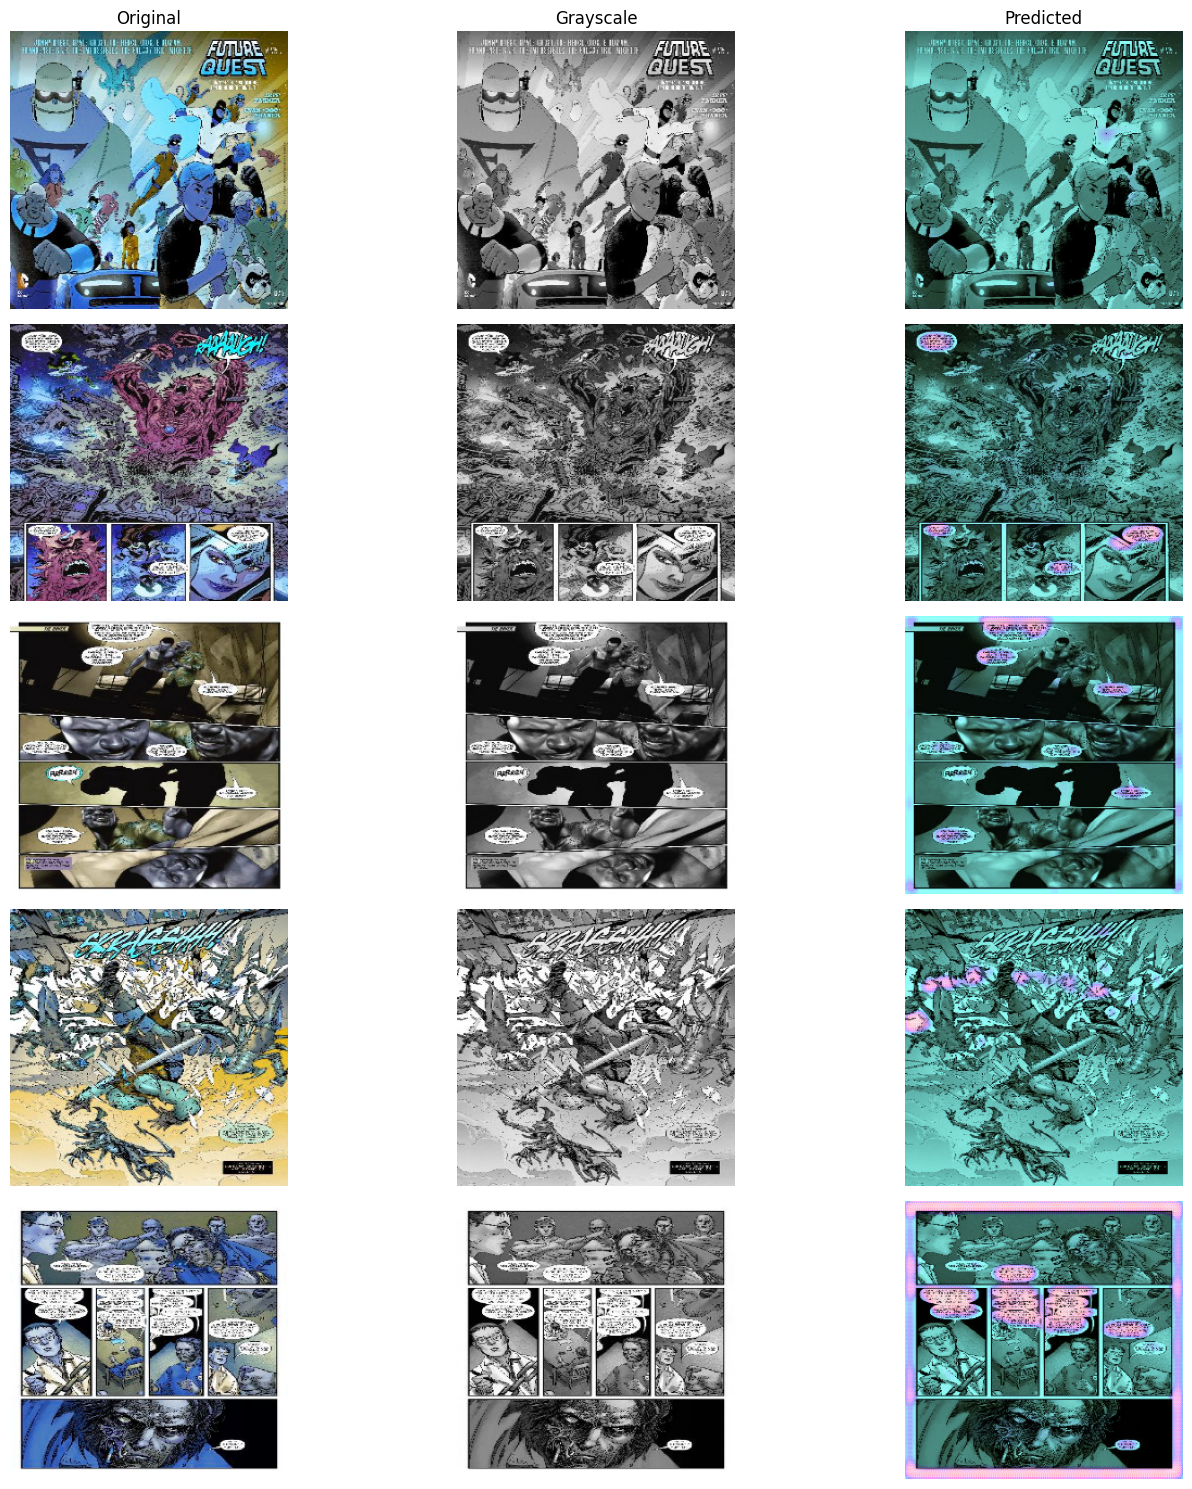

In [8]:
def plot_results(model, X, y_true_rgb, num_samples=5):
    """Plot original, grayscale and predicted images."""
    # Get predictions
    y_pred_hs = model.predict(X[:num_samples])
    
    # Create full HSV images (combine predicted H,S with original V)
    v_channel = (X[:num_samples] / 2 + 0.5)  # Denormalize V channel
    y_pred_hsv = np.concatenate([y_pred_hs, v_channel], axis=-1)
    
    # Convert to RGB for visualization
    y_pred_rgb = hsv_to_rgb(y_pred_hsv)
    
    # Plot results
    plt.figure(figsize=(15, 3*num_samples))
    for i in range(num_samples):
        # Original
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(y_true_rgb[i])
        plt.title('Original' if i == 0 else '')
        plt.axis('off')
        
        # Grayscale
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title('Grayscale' if i == 0 else '')
        plt.axis('off')
        
        # Predicted
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred_rgb[i])
        plt.title('Predicted' if i == 0 else '')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some test results
plot_results(model, X_test, y_test)